<a href="https://colab.research.google.com/github/prnt84/The-Emotion-Story/blob/main/main_emotion_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 #api to install kaggle datasets
 ! pip install -q kaggle 

In [ ]:
#uploading kaggle.json file 
from google.colab import files 

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneeta8","key":"703f18299b21929ffc7dc9c0fc04d2da"}'}

In [ ]:
#making a directory to store the kaggle file
!mkdir -p ~/.kaggle 
! cp kaggle.json ~/.kaggle/ 

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json #changing the permissions

In [ ]:
#importing the FER2013 dataset from kaggle link
! kaggle datasets download -d deadskull7/fer2013 

 84% 81.0M/96.6M [00:03<00:00, 21.5MB/s]
100% 96.6M/96.6M [00:03<00:00, 31.9MB/s]


In [ ]:
#unzipping the csv file
!unzip \*.zip  && rm *.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [ ]:
#importing the necessary libraries
import os,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD,RMSprop,Adam

#reading the csv file and storing it in dataframe df
df=pd.read_csv('/content/fer2013.csv')

#printing the first five elements of the dataframe
print(df.head())
#making lists for storing training data and validation data
X_train,train_y,X_test,test_y=[],[],[],[] 


for index, row in df.iterrows():
    val=row['pixels'].split(" ") #pixels are separated and stored in val
    try:
      #if the Usage col contains 'Training' it is to be used for training 
        if 'Training' in row['Usage']: 
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
      #if the Usage col contains 'PublicTest' it is to be used for validation 
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")

#initializing the parameters 
num_features = 64
num_labels = 7 #for seven emotions
batch_size = 64 #64 images will be processed in each step
epochs = 50 #50 cycles of training the data
width, height = 48, 48 #of the images

#converting the training and validation subsets into numpy array of data type float32
X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

#these contain the labels 
train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)


#normalizing data between 0 and 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print(f"shape:{X_train.shape}")


   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
shape:(28709, 48, 48, 1)


In [ ]:
#the architecture of the deep cnn model

model = Sequential()
model.add(Convolution2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Convolution2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#fully connected layers
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))
model.summary() #information about the layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [ ]:
#Compliling the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

#Training the model
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)

Epoch 1/50
449/449 [==============================] - 90s 129ms/step - loss: 2.2812 - accuracy: 0.2039 - val_loss: 1.8371 - val_accuracy: 0.2494
Epoch 2/50
449/449 [==============================] - 55s 123ms/step - loss: 1.8280 - accuracy: 0.2495 - val_loss: 1.7339 - val_accuracy: 0.2878
Epoch 3/50
449/449 [==============================] - 55s 123ms/step - loss: 1.7573 - accuracy: 0.2870 - val_loss: 1.6264 - val_accuracy: 0.3296
Epoch 4/50
449/449 [==============================] - 56s 124ms/step - loss: 1.6516 - accuracy: 0.3374 - val_loss: 1.5111 - val_accuracy: 0.4074
Epoch 5/50
449/449 [==============================] - 55s 124ms/step - loss: 1.5345 - accuracy: 0.3937 - val_loss: 1.4394 - val_accuracy: 0.4361
Epoch 6/50
449/449 [==============================] - 56s 124ms/step - loss: 1.4609 - accuracy: 0.4260 - val_loss: 1.3993 - val_accuracy: 0.4480
Epoch 7/50
449/449 [==============================] - 56s 124ms/step - loss: 1.4185 - accuracy: 0.4471 - val_loss: 1.3643 - val_ac

In [ ]:
fer_json = model.to_json()
with open("fernew10.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fernew10.h5")

In [ ]:
score = model.evaluate(X_test, test_y, verbose=0)
print ("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

model accuracy: 64.31%


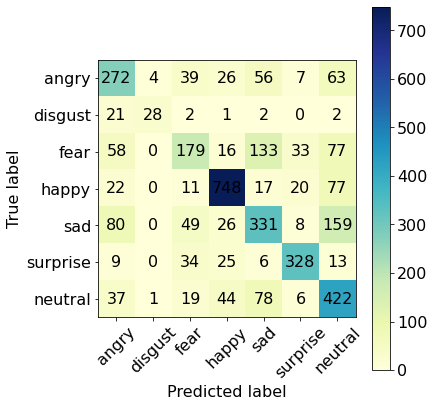

In [ ]:

y_prob = model.predict(X_test, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in test_y]
from sklearn.metrics import confusion_matrix

emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(emotions))
    ax.set_xticks(ticks)
    ax.set_xticklabels(emotions, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(emotions)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()